# Nowcasting CPI
geoff pidcock | PacifImpact | Sept 2020

## Scope
- Setup
- Review current CPI measures, and expert opinions on their movement (for evaluation purposes)
- Attempt to nowcast using the existing `Port Calls` product (produced by the [AIS Task Team](https://comtrade.un.org/data/cache/AISdashboardMethodology.pdf)
- Attempt to nowcast using novel AIS data products

In [37]:
# Setup
import os
from dotenv import load_dotenv, find_dotenv

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()

# load up the entries as environment variables
load_dotenv(dotenv_path)

DBUNAME = os.environ.get("DBUNAME")
DBPASSWORD = os.environ.get("DBPASSWORD")
DBHOST = os.environ.get("DBHOST")
DBPORT = os.environ.get("DBPORT")
DBNAME = os.environ.get("DBNAME")

import sqlalchemy
import psycopg2

connection_str = 'postgresql+psycopg2://'+DBUNAME+':'+DBPASSWORD+'@'+DBHOST+':'+DBPORT+'/'+DBNAME

In [38]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pickle
from matplotlib import rcParams

In [51]:
try:
    engine = sqlalchemy.create_engine(connection_str)
    conn = engine.connect()
except:
    print('Database connection error - check creds')

### one time upload of port call data to postgres

In [4]:
# one time upload of port call data to postgres
data_port = pd.read_csv('../data/raw/daily_port_calls.csv')
data_port_prep = data_port.loc[
    data_port['GID_0'].isin(['FJI','VUT','KIR','COK','SLB','PLW'])
    ,['date-entry','GID_0','port-name','port_calls']
].copy()
data_port_prep.GID_0.value_counts()

FJI    896
SLB    472
VUT    243
KIR    100
PLW     92
COK     39
Name: GID_0, dtype: int64

In [13]:
country_map = {
    'FJI':'fj'
    ,'SLB':'sb'
    ,'COK':'ck'
    ,'PLW':'pw'
    ,'VUT':'vu'
    ,'KIR':'ki'
}

region_map = {
    'FJI':'melanesia'
    ,'SLB':'melanesia'
    ,'COK':'polynesia'
    ,'PLW':'micronesia'
    ,'VUT':'melanesia'
    ,'KIR':'polynesia'
}

data_port_prep['country'] = data_port_prep.GID_0.apply(lambda x: country_map.get(x))
data_port_prep['region'] = data_port_prep.GID_0.apply(lambda x: region_map.get(x))
data_port_prep['date-entry'] = pd.to_datetime(data_port_prep['date-entry']
                                             ,format='%m/%d/%Y')
data_port_prep['key'] = data_port_prep['country']+'--'+data_port_prep['port-name']+'--'+\
data_port_prep['date-entry'].astype(str)

data_port_prep.head()

,date-entry,GID_0,port-name,port_calls,country,region,key
11,2020-08-21,FJI,Lautoka Harbor,1,fj,melanesia,fj--Lautoka Harbor--2020-08-21
609,2020-08-21,SLB,Honiara,0,sb,melanesia,sb--Honiara--2020-08-21
610,2020-08-21,SLB,Honiara,1,sb,melanesia,sb--Honiara--2020-08-21
747,2020-08-22,SLB,Port Noro,4,sb,melanesia,sb--Port Noro--2020-08-22
2141,2020-08-21,FJI,Suva Harbor,0,fj,melanesia,fj--Suva Harbor--2020-08-21


In [7]:
# confirm tables are present as expected
engine.table_names() 

['test', 'test2', 'stg_country_metrics', 'country_metrics', 'stg_ais']

In [14]:
data_port_prep[['key','region','country','port-name','date-entry','port_calls']]\
.to_sql('ais_port_calls'
        ,con = engine
        ,if_exists='replace'
        ,index=False
        ,method='multi')

In [15]:
pd.read_sql("select * from public.ais_port_calls limit 5",con=engine)

,key,region,country,port-name,date-entry,port_calls
0,fj--Lautoka Harbor--2020-08-21,melanesia,fj,Lautoka Harbor,2020-08-21,1
1,sb--Honiara--2020-08-21,melanesia,sb,Honiara,2020-08-21,0
2,sb--Honiara--2020-08-21,melanesia,sb,Honiara,2020-08-21,1
3,sb--Port Noro--2020-08-22,melanesia,sb,Port Noro,2020-08-22,4
4,fj--Suva Harbor--2020-08-21,melanesia,fj,Suva Harbor,2020-08-21,0


# Review current CPI numbers

In [16]:
pd.read_sql(
"""
select name, country, frequency, min(date), max(date)
from public.country_metrics
where true
and category = 'CPI'
-- and country in ('fj','vu','ck','ki','pw','sb','PW','kir')
group by 1,2,3
order by 1,2,3

"""
,con=engine
)

,name,country,frequency,min,max
0,CPI_2006_ALCOHOL/TOBACCO,kir,monthly,2018-01-01,2019-12-01
1,CPI_2006_ALL ITEMS,kir,monthly,2018-01-01,2019-12-01
2,CPI_2006_CLOTHING,kir,monthly,2018-01-01,2019-12-01
3,CPI_2006_EDUCATION & HEALTH,kir,monthly,2018-01-01,2019-12-01
4,CPI_2006_FOOD,kir,monthly,2018-01-01,2019-12-01
5,CPI_2006_HOUSEHOLD OPERATION,kir,monthly,2018-01-01,2019-12-01
6,CPI_2006_HOUSING,kir,monthly,2018-01-01,2019-12-01
7,CPI_2006_NON-ALCOHOLIC DRINKS,kir,monthly,2018-01-01,2019-12-01
8,CPI_2006_RECREATION,kir,monthly,2018-01-01,2019-12-01
9,CPI_2006_TRANSPORTATION,kir,monthly,2018-01-01,2019-12-01


In [30]:
# todo - figure out how to handle quarterly (down-sample through averaging?)
# potentially look at F&B -- ethel suspected it would correlate well.
data_cpi = pd.read_sql("""
with model as (
    select
        case 
            when country in ('fj','vn','sb') then 'melanesia'
            when country in ('ck','kir') then 'polynesia'
            when country in ('PW','pw','pl') then 'micronesia'
         end as region
        ,case when country = 'kir' then 'ki'
            else lower(country) end as country    
        ,case
            when lower(country) = 'fj' then to_date(date,'YYYY-MM')
            else to_date(date,'YYYY-MM-DD')
         end as date
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Total' then cast(value as float)
            when lower(country) = 'pw' and name = 'CPI_2016_Total' then cast(value as float)
            when lower(country) = 'kir' and name = 'CPI_2006_ALL ITEMS' then cast(value as float)
            when lower(country) = 'sb' and name = 'CPI_2017_Total' then cast(value as float)
            else 0 end as cpi_total
    from public.country_metrics
    where true
        and lower(category) = 'cpi'
        and frequency = 'monthly'
        and lower(country) in ('fj','vn','ck','kir','pw','pl','sb')
--        and date between '2019-01-01' and '2019-12-01'    
)
select 
    region
    ,country
    ,date
    ,sum(cpi_total) as cpi_total
from model 
group by 1,2,3
order by 1,2,3
;;

""",con=engine)
data_cpi

,region,country,date,cpi_total
0,melanesia,fj,2018-01-01,110.4
1,melanesia,fj,2018-02-01,111.1
2,melanesia,fj,2018-03-01,111.6
3,melanesia,fj,2018-04-01,113.5
4,melanesia,fj,2018-05-01,114.0
...,...,...,...,...
74,polynesia,ki,2019-08-01,125.0
75,polynesia,ki,2019-09-01,125.2
76,polynesia,ki,2019-10-01,125.4
77,polynesia,ki,2019-11-01,125.4


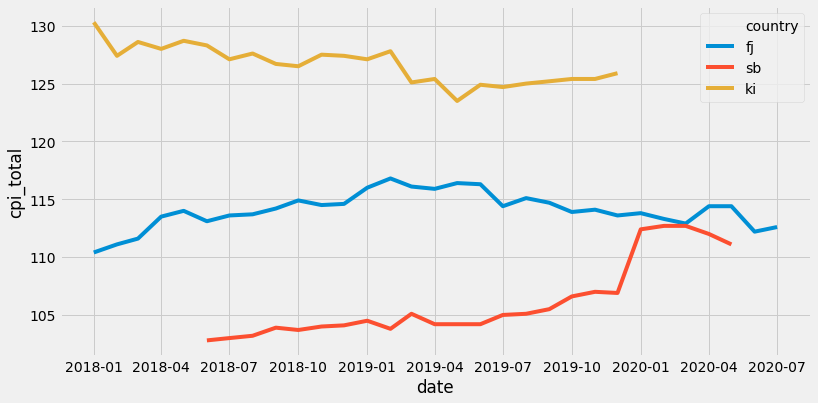

In [32]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='cpi_total',hue='country', data=data_cpi)
plt.show()

# Review current Trade Numbers

In [40]:
# analytics query
data_trade2 = pd.read_sql(
"""
        with model as (
            select
                date
                ,case 
                    when country in ('fj','vn','sb') then 'melanesia'
                    when country in ('ck','ki') then 'polynesia'
                    when country in ('pw','pl') then 'micronesia'
                 end as region
                ,case when country = 'pl' then 'pw'
                     when country = 'vn' then 'vu'
                     else country end as country
                ,case 
                    when (country = 'vn' and name='total-imports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='imports-cif') then cast(value as float)
                    when (country not in ('pl','vn') and name='imports-cif') then 1000*cast(value as float)
                    else 0 
                 end as trade_imports
                ,case 
                    when (country = 'vn' and name='total-exports') then 1000000*cast(value as float)
                    when (country = 'pl' and name='exports-fob-total') then cast(value as float)
                    when (country not in ('pl','vn') and name='exports-fob-total') then 1000*cast(value as float)
                    else 0 
                 end as trade_exports
            from public.country_metrics
            where true
                and category = 'trade'
                and frequency = 'monthly'
                and country in ('fj','vn','ck','ki','pw','pl','sb')
                and date between '2019-01-01' and '2020-07-31'
        )
        select 
            region
            ,country
            ,date            
            ,sum(trade_imports) as trade_imports
            ,sum(trade_exports) as trade_exports
            ,sum(trade_imports) + sum(trade_exports) as trade_volume
            ,sum(trade_exports) - sum(trade_imports) as trade_balance
            ,sum(trade_exports)/sum(trade_imports) as export_import_ratio
        from model   
        group by 1,2,3
        order by 1,2,3   
"""
,con=engine,parse_dates='date')
data_trade2

,region,country,date,trade_imports,trade_exports,trade_volume,trade_balance,export_import_ratio
0,melanesia,fj,2019-01-01,6.030260e+08,2.091587e+08,8.121847e+08,-3.938673e+08,0.346849
1,melanesia,fj,2019-02-01,3.612810e+08,1.602607e+08,5.215417e+08,-2.010203e+08,0.443590
2,melanesia,fj,2019-03-01,3.864050e+08,1.682713e+08,5.546763e+08,-2.181337e+08,0.435479
3,melanesia,fj,2019-04-01,4.271140e+08,1.666927e+08,5.938067e+08,-2.604213e+08,0.390277
4,melanesia,fj,2019-05-01,4.626890e+08,1.790928e+08,6.417818e+08,-2.835962e+08,0.387069
...,...,...,...,...,...,...,...,...
67,polynesia,ki,2019-08-01,1.564470e+07,2.192664e+06,1.783737e+07,-1.345204e+07,0.140154
68,polynesia,ki,2019-09-01,1.484654e+07,1.375781e+06,1.622232e+07,-1.347076e+07,0.092667
69,polynesia,ki,2019-10-01,1.619253e+07,7.567212e+05,1.694925e+07,-1.543581e+07,0.046733
70,polynesia,ki,2019-11-01,1.269483e+07,1.412641e+06,1.410747e+07,-1.128219e+07,0.111277


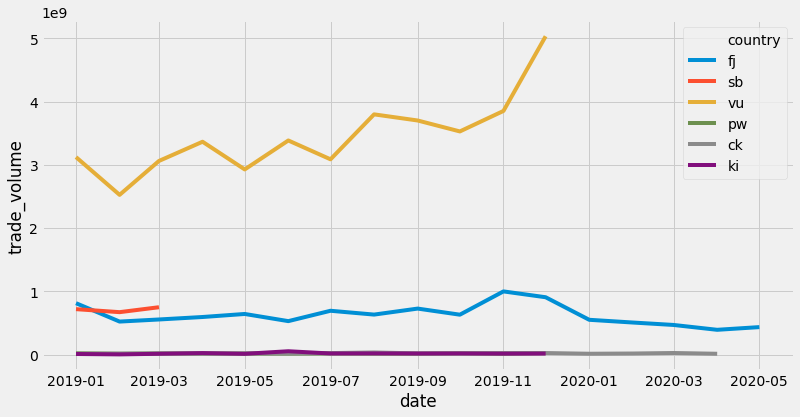

In [42]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='trade_volume',hue='country', data=data_trade2)
plt.show()

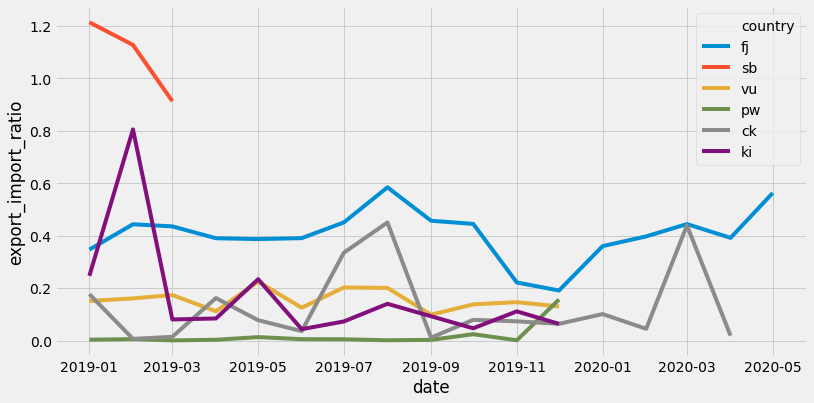

In [43]:
import matplotlib.style as style
import seaborn as sns
style.use('fivethirtyeight')
plt.clf
f = plt.figure(figsize=(12,6))
sns.lineplot(x='date',y='export_import_ratio',hue='country', data=data_trade2)
plt.show()

# Review GDP Numbers

- These numbers are typically only yearly [aggregated here](https://docs.google.com/spreadsheets/d/14fgVksd_I5HFIkQViVthQ7PO-JqKSX0DM-bF9sDtolw/edit#gid=0)
- There may be poor coverage between GDP and our other dataset

In [45]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'trade'
group by 1
""",con=engine)

,country,min,max
0,pl,2018-01-01,2019-12-01
1,ki,2016-01-01,2019-12-01
2,sb,2018-01-01,2019-03-01
3,ws,1/01/2018,1/12/2019
4,fj,2014-01-01,2020-05-01
5,vn,2016-12-01,2019-12-01
6,ck,2017-01-01,2020-04-01


In [46]:
pd.read_sql("""
select distinct category from public.country_metrics
""",con=engine)

,category
0,trade
1,CPI
2,GDP
3,tourism


In [47]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'tourism'
group by 1
""",con=engine)
# Missing Ki, only small range of overlap in FJ (one year) - though there are longer aggregates in our raw data for FJ

,country,min,max
0,pl,2007-06-01,2020-01-01
1,sb,2016-01-01 00:00:00,2020-01-01 00:00:00
2,fj,2018-01-01 00:00:00,2020-06-01 00:00:00
3,vn,2015-03-01,2020-03-01
4,ck,2018-01-01 00:00:00,2020-03-01 00:00:00


In [48]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'CPI'
group by 1
""",con=engine)
# only one year of overlap here as well

,country,min,max
0,sb,2018-06-01,2020-05-01
1,kir,2018-01-01,2019-12-01
2,fj,2018-01,2020-07
3,PW,2018-03-01,2020-03-01


In [49]:
pd.read_sql("""
select
    country
    ,min(date)    
    ,max(date)
from public.country_metrics
where category = 'GDP'
group by 1
""",con=engine)

,country,min,max
0,wsm,Dec-17,Sep-19
1,ck,Dec-17,Sep-19


In [54]:
pd.read_sql("""
select distinct name
from public.country_metrics
where category = 'GDP'
and country = 'ck'
--order by value desc
""",con=engine)

,name
0,"GDP_Arts, Recreation, Other Services"
1,GDP_Taxes on Products
2,"GDP_Electricity, Water, Waste"
3,GDP_GDP at Market Prices
4,GDP_Finance and Insurance
5,GDP_Information and Communication
6,GDP_Human Health and Social Work
7,GDP_Fishing incl Pearls
8,GDP_Goods-producing industries
9,GDP_Ownership of dwellings


In [65]:
pd.read_sql("""
select *
from public.country_metrics
where category = 'GDP'
and country = 'ck'
and name='GDP_GDP at Market Prices'
order by date
--order by value desc
""",con=engine)

,metric_key,frequency,country,category,source,name,date,value,properties
0,GDP_GDP at Market Prices_Dec-17,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Dec-17,127.8,{currency = nzd}
1,GDP_GDP at Market Prices_Dec-18,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Dec-18,139.6,{currency = nzd}
2,GDP_GDP at Market Prices_Dec-19,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Dec-19,153.4,{currency = nzd}
3,GDP_GDP at Market Prices_Jun-17,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Jun-17,117.0,{currency = nzd}
4,GDP_GDP at Market Prices_Jun-18,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Jun-18,125.0,{currency = nzd}
5,GDP_GDP at Market Prices_Jun-19,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Jun-19,146.2,{currency = nzd}
6,GDP_GDP at Market Prices_Mar-18,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Mar-18,115.3,{currency = nzd}
7,GDP_GDP at Market Prices_Mar-19,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Mar-19,118.6,{currency = nzd}
8,GDP_GDP at Market Prices_Mar-20,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Mar-20,138.9,{currency = nzd}
9,GDP_GDP at Market Prices_Sep-17,quartely,ck,GDP,National_stat_ck,GDP_GDP at Market Prices,Sep-17,136.2,{currency = nzd}


# Attempt to Nowcast GDP Port Calls
For the following regions 
- Melanesia: Fiji, Vanuatu
- Polynesia: Kiribati, Cook Islands
- Micronesia: Palau

Target
- GDP (CK)
- CPI (Others)
- Trade Volume (imports + exports)

Feature gaps
- Trade - None
- Tourism - VU, KI, PW

# CK and GDP

In [69]:
# GDP
ck_gdp = pd.read_sql(
"""
--with model as (
select
    to_date(date,'Mon-YY') as date_from
    ,to_date(date,'Mon-YY') + interval '4 month' - interval '1 day' as date_to
    ,cast(value as float) as gdp
    ,(cast(value as float)/(lag(cast(value as float),1) over (order by to_date(date,'Mon-YY') asc))-1) as gdp_growth    
    ,(cast(value as float)/(lag(cast(value as float),4) over (order by to_date(date,'Mon-YY') asc))-1) as gdp_growth_annualised
from public.country_metrics
    where true
    and category = 'GDP'
    and country = 'ck'
--    and name = 'GDP_Restaurants and Bars'
    and name='GDP_GDP at Market Prices' 
--)
"""
,con=engine)
ck_gdp

,date_from,date_to,gdp,gdp_growth,gdp_growth_annualised
0,2017-06-01,2017-09-30,117.0,NaN,NaN
1,2017-09-01,2017-12-31,136.2,0.164103,NaN
2,2017-12-01,2018-03-31,127.8,-0.061674,NaN
3,2018-03-01,2018-06-30,115.3,-0.097809,NaN
4,2018-06-01,2018-09-30,125.0,0.084128,0.068376
5,2018-09-01,2018-12-31,144.3,0.154400,0.059471
6,2018-12-01,2019-03-31,139.6,-0.032571,0.092332
7,2019-03-01,2019-06-30,118.6,-0.150430,0.028621
8,2019-06-01,2019-09-30,146.2,0.232715,0.169600
9,2019-09-01,2019-12-31,157.2,0.075239,0.089397


In [103]:
pd.read_sql(
"""
with dates as (
SELECT date '2017-06-01' + interval '1' month * s.a AS date
  FROM generate_series(0,36,1) AS s(a)
)
, dates_countries as (
    select d.date
    ,c.country
    from dates d
    cross join (select distinct country from stg_trade_agg) c
)
select * from dates_countries
"""
,con=engine)

,date,country
0,2017-06-01,ki
1,2017-06-01,sb
2,2017-06-01,fj
3,2017-06-01,vn
4,2017-06-01,ck
...,...,...
217,2020-06-01,sb
218,2020-06-01,fj
219,2020-06-01,vn
220,2020-06-01,ck


In [270]:
# modelled features
data_model = pd.read_sql(
"""
with dates as (
    SELECT 
        date '2017-07-01' + interval '1' month * s.a AS date
    FROM generate_series(0,37,1) AS s(a)
)
,dates_countries as (
    select 
        d.date
        ,c.region
        ,c.country
    from dates d
    cross join (select distinct region, country from stg_trade_agg) c
)
,agg_port_calls as (
    select
        country
        ,date_trunc('month',"date-entry") as date
        ,sum(port_calls) as port_calls
    from public.ais_port_calls
    group by 1,2
)
,ck_gdp as (
    select
        to_date(date,'Mon-YY') as date_from
        ,to_date(date,'Mon-YY') + interval '4 month' - interval '1 day' as date_to
        ,cast(value as float) as gdp
        ,(cast(value as float)/(lag(cast(value as float),1) over (order by to_date(date,'Mon-YY') asc))-1) as gdp_growth    
        ,(cast(value as float)/(lag(cast(value as float),4) over (order by to_date(date,'Mon-YY') asc))-1) as gdp_growth_annualised
    from public.country_metrics
    where true
        and category = 'GDP'
        and country = 'ck'
        and name='GDP_GDP at Market Prices' 
)        
,model as (
select 
    d.date as date_from
    ,d.date + interval '1 month' - interval '1 day' as date_to
    ,d.region
    ,d.country
    ,g.gdp
    ,g.gdp_growth
    ,g.gdp_growth_annualised
    ,t.trade_imports
    ,t.trade_exports
    ,t.trade_volume
    ,t.export_import_ratio
    ,cast(v.visitor_arrivals as float) as visitor_arrivals
    ,a.cargo_uniq_mmsi_count
    ,a.cargo_time_in_port_seconds
    ,a.tanker_uniq_mmsi_count
    ,a.tanker_time_in_port_seconds
    ,a.fishing_uniq_mmsi_count
    ,a.fishing_time_in_port_seconds
    ,a.leisure_uniq_mmsi_count
    ,a.leisure_time_in_port_seconds
    ,p.port_calls
from dates_countries d
left join ck_gdp g
    on left(cast((d.date + interval '1 month' - interval '1 day') as text),10) = left(cast(g.date_to as text),10)
left join stg_trade_agg t
    on left(cast(d.date as text),10) = cast(t.date as text)
    and d.country = t.country
left join stg_tourism_agg v 
    on left(cast(d.date as text),10) = left(cast(v.date as text),10)
    and d.country = v.country
left join stg_ais_agg a 
    on left(cast(d.date as text),10) = cast(a.date as text)
    and d.country = a.country
left join agg_port_calls p 
    on left(cast(d.date as text),10) = left(cast(p.date as text),10)
    and d.country = p.country
where d.country = 'ck'
)
select * from model where date_from >= '2019-01-01' -- most complete data region
"""
,con=engine
)

In [160]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_from                     20 non-null     datetime64[ns]
 1   date_to                       20 non-null     datetime64[ns]
 2   region                        20 non-null     object        
 3   country                       20 non-null     object        
 4   gdp                           6 non-null      float64       
 5   gdp_growth                    6 non-null      float64       
 6   gdp_growth_annualised         6 non-null      float64       
 7   trade_imports                 12 non-null     float64       
 8   trade_exports                 12 non-null     float64       
 9   trade_volume                  12 non-null     float64       
 10  export_import_ratio           12 non-null     float64       
 11  visitor_arrivals              15 n

In [162]:
data_model[~data_model.gdp.isna()]

,date_from,date_to,region,country,gdp,gdp_growth,gdp_growth_annualised,trade_imports,trade_exports,trade_volume,...,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
2,2019-03-01,2019-03-31,polynesia,ck,139.6,-0.032571,0.092332,16818000.0,240000.0,17058000.0,...,10659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2019-06-01,2019-06-30,polynesia,ck,118.6,-0.150430,0.028621,16850000.0,606000.0,17456000.0,...,15928.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
8,2019-09-01,2019-09-30,polynesia,ck,146.2,0.232715,0.169600,17783419.0,198590.0,17982009.0,...,17913.0,8299.0,307741.0,148.0,151767.0,422.0,7497.0,447.0,516221.0,3.0
11,2019-12-01,2019-12-31,polynesia,ck,157.2,0.075239,0.089397,22352000.0,1424304.0,23776304.0,...,14567.0,2805.0,435432.0,692.0,270627.0,NaN,NaN,967.0,69912.0,3.0
14,2020-03-01,2020-03-31,polynesia,ck,153.4,-0.024173,0.098854,NaN,NaN,NaN,...,5814.0,1598.0,300645.0,6935.0,263897.0,NaN,NaN,10.0,12112.0,1.0
17,2020-06-01,2020-06-30,polynesia,ck,138.9,-0.094524,0.171164,NaN,NaN,NaN,...,NaN,1887.0,236595.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [150]:
data_model.columns

Index(['date_from', 'date_to', 'region', 'country', 'gdp', 'gdp_growth',
       'gdp_growth_annualised', 'trade_imports', 'trade_exports',
       'trade_volume', 'export_import_ratio', 'visitor_arrivals',
       'cargo_uniq_mmsi_count', 'cargo_time_in_port_seconds',
       'tanker_uniq_mmsi_count', 'tanker_time_in_port_seconds',
       'fishing_uniq_mmsi_count', 'fishing_time_in_port_seconds',
       'leisure_uniq_mmsi_count', 'leisure_time_in_port_seconds',
       'port_calls'],
      dtype='object')

Text(0.01, 0.975, 'Cook Islands: Trade and AIS Stats Correlation with GDP Growth since 2019\n')

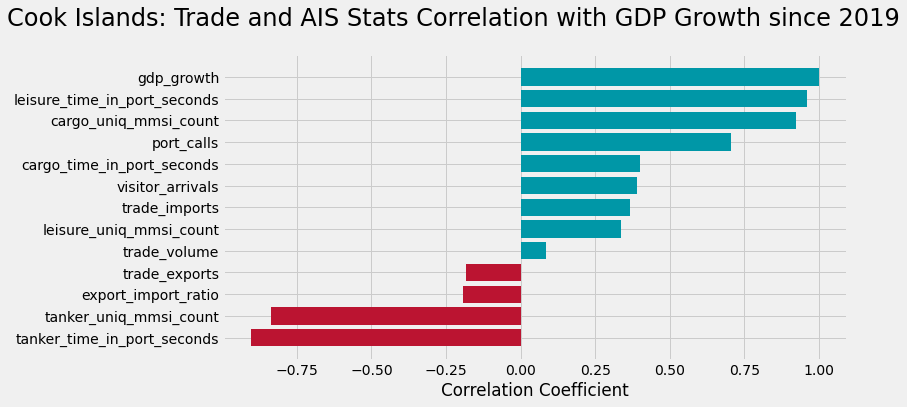

In [271]:
coef = data_model.drop(columns=['fishing_uniq_mmsi_count'
                                ,'fishing_time_in_port_seconds'
                                ,'gdp'
                                ,'gdp_growth_annualised']).corr()\
.sort_values(by='gdp_growth',ascending=True)['gdp_growth']
plt.clf
f = plt.figure(figsize=(12,6))
plt.barh(coef.index
        ,coef
        ,color=(coef>0).map({True:'#0097a7',False:'#bb1431'}))

plt.xlabel('Correlation Coefficient')
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.suptitle('Cook Islands: Trade and AIS Stats Correlation with GDP Growth since 2019\n',x=0.01, y=.975,fontsize=24,ha='left')
#plt.figtext(0.01,0.87,'Based on 6 quarterly measures',fontdict={'fontsize':18,'ha':'left'})    

In [235]:
data_model_plot.columns[6:].tolist()+[data_model_plot.columns[5]]

['gdp_growth_annualised',
 'trade_imports',
 'trade_exports',
 'trade_volume',
 'export_import_ratio',
 'visitor_arrivals',
 'cargo_uniq_mmsi_count',
 'cargo_time_in_port_seconds',
 'tanker_uniq_mmsi_count',
 'tanker_time_in_port_seconds',
 'fishing_uniq_mmsi_count',
 'fishing_time_in_port_seconds',
 'leisure_uniq_mmsi_count',
 'leisure_time_in_port_seconds',
 'port_calls',
 'gdp_growth']

In [236]:
data_model_plot = data_model[~data_model.gdp_growth.isna()].copy()
for c in data_model_plot.columns[6:].tolist()+[data_model_plot.columns[5]]:
    data_model_plot[c] = (data_model_plot[c]-data_model_plot[c].min())/(data_model_plot[c].max()-data_model_plot[c].min())

In [237]:
data_model_plot.set_index('date_to',inplace=True)

''

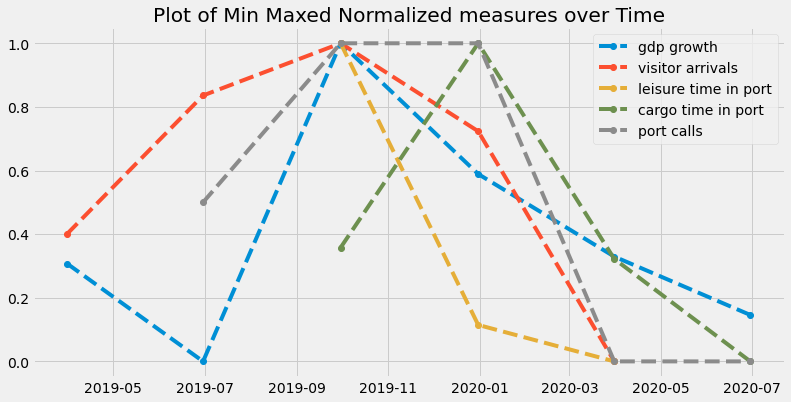

In [240]:
plt.clf
f = plt.figure(figsize=(12,6))
plt.plot(data_model_plot.gdp_growth,marker='o',linestyle='--',label='gdp growth')
plt.plot(data_model_plot.visitor_arrivals,marker='o',linestyle='--',label='visitor arrivals')
plt.plot(data_model_plot.leisure_time_in_port_seconds,marker='o',linestyle='--',label='leisure time in port')
plt.plot(data_model_plot.cargo_time_in_port_seconds,marker='o',linestyle='--',label='cargo time in port')
plt.plot(data_model_plot.port_calls,marker='o',linestyle='--',label='port calls')
plt.legend(loc='upper right')
plt.title("Plot of Min Maxed Normalized measures over Time")
;

# Data prep and model fit

In [272]:
data_model_prep = data_model[['date_to','gdp_growth','trade_imports','trade_exports'
                              ,'trade_volume','visitor_arrivals','cargo_uniq_mmsi_count'
                              ,'cargo_time_in_port_seconds','tanker_uniq_mmsi_count'
                              ,'tanker_time_in_port_seconds','fishing_uniq_mmsi_count'
                              ,'fishing_time_in_port_seconds','leisure_uniq_mmsi_count'
                              ,'leisure_time_in_port_seconds','port_calls']].copy()
data_model_prep.set_index('date_to',inplace=True)
data_model_prep.head()

,gdp_growth,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
date_to,,,,,,,,,,,,,,
2019-01-31,NaN,10058000.0,1780000.0,11838000.0,10128.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-28,NaN,14069000.0,90000.0,14159000.0,7608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-31,-0.032571,16818000.0,240000.0,17058000.0,10659.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-30,NaN,12186000.0,1975000.0,14161000.0,13739.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2019-05-31,NaN,17892000.0,1389000.0,19281000.0,14430.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0


In [273]:
# log difference transformation
for col in ['trade_imports','trade_exports'
          ,'trade_volume','visitor_arrivals','cargo_uniq_mmsi_count'
          ,'cargo_time_in_port_seconds','tanker_uniq_mmsi_count'
          ,'tanker_time_in_port_seconds','fishing_uniq_mmsi_count'
          ,'fishing_time_in_port_seconds','leisure_uniq_mmsi_count'
          ,'leisure_time_in_port_seconds','port_calls']:
    data_model_prep[col] = np.log(data_model_prep[col]).diff()

# standardization
for col in data_model_prep.columns[1:]:
    data_model_prep[col] = (data_model_prep[col]-data_model_prep[col].mean())/data_model_prep[col].std()    

In [274]:
data_model_prep2 = data_model_prep.drop(labels=
                     ['fishing_uniq_mmsi_count','fishing_time_in_port_seconds'
                      ,'tanker_uniq_mmsi_count','tanker_time_in_port_seconds'
                      ,'leisure_uniq_mmsi_count','leisure_time_in_port_seconds'],axis=1).copy()

In [275]:
data_model_prep3 = data_model_prep2.drop(data_model_prep2.index[0]).copy()

In [285]:
data_model_prep3.iloc[7:-4,:]

,gdp_growth,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,port_calls
date_to,,,,,,,,
2019-09-30,0.232715,-0.850863,-1.875469,-1.633816,0.041304,NaN,NaN,-0.927552
2019-10-31,NaN,-0.167488,1.013838,0.065813,-0.298471,-0.236159,-0.653414,-0.718512
2019-11-30,NaN,0.792261,0.153569,0.651053,-0.630333,1.024403,0.730565,0.890417
2019-12-31,0.075239,0.019805,0.007921,0.017882,0.540770,-2.028834,0.689039,0.085953
2020-01-31,NaN,-2.255438,-0.032105,-1.701616,-1.492948,-1.016817,-1.696833,-0.718512
2020-02-29,NaN,0.985452,-0.181832,0.680034,-0.319621,0.049325,-1.142427,0.085953
2020-03-31,-0.024173,0.219079,1.232180,1.066566,-1.719804,0.718098,1.697071,-1.289288
2020-04-30,NaN,-1.179449,-1.654769,-1.857744,NaN,0.131147,-0.596951,1.461193


In [288]:
data_model_prep4 = data_model_prep3.iloc[0:10,:5].copy()
data_model_prep4

,gdp_growth,trade_imports,trade_exports,trade_volume,visitor_arrivals
date_to,,,,,
2019-02-28,NaN,1.081573,-1.404187,0.476659,-1.088835
2019-03-31,-0.032571,0.556546,0.551628,0.496166,1.664895
2019-04-30,NaN,-1.116268,1.107417,-0.508146,1.296571
2019-05-31,NaN,1.243497,-0.105744,0.826157,0.391942
2019-06-30,-0.150430,-0.240299,-0.341245,-0.274350,0.611506
2019-07-31,NaN,0.021302,1.177819,0.727430,0.863146
2019-08-31,NaN,0.890292,0.350979,0.967911,0.139879
2019-09-30,0.232715,-0.850863,-1.875469,-1.633816,0.041304
2019-10-31,NaN,-0.167488,1.013838,0.065813,-0.298471


In [289]:
mod = sm.tsa.DynamicFactor(data_model_prep4,k_factors = 1, factor_order=2, error_order=2,enforce_stationarity=False)
res = mod.fit(disp=False)

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [290]:
resultdf = pd.DataFrame({'Nowcasted Real GDP Growth':res.predict()['gdp_growth'],'Actual Real GDP Growth':data_model_prep4['gdp_growth']})
resultdf

,Nowcasted Real GDP Growth,Actual Real GDP Growth
2019-02-28,0.0,NaN
2019-03-31,0.0,-0.032571
2019-04-30,0.0,NaN
2019-05-31,0.0,NaN
2019-06-30,0.0,-0.150430
2019-07-31,0.0,NaN
2019-08-31,0.0,NaN
2019-09-30,0.0,0.232715
2019-10-31,0.0,NaN
2019-11-30,0.0,NaN


# FJ and CPI

In [253]:
pd.read_sql(
"""
select distinct trade_imports<0 as condition, country from stg_trade_agg
"""
,con=engine)

,condition,country
0,False,vn
1,False,ck
2,False,fj
3,False,pw
4,False,sb
5,False,ki


In [299]:
data_fj = pd.read_sql("""
with dates as (
    SELECT 
        date '2017-07-01' + interval '1' month * s.a AS date
    FROM generate_series(0,37,1) AS s(a)
)
,dates_countries as (
    select 
        d.date
        ,c.region
        ,c.country
    from dates d
    cross join (select distinct region, country from stg_trade_agg) c
)
,agg_port_calls as (
    select
        country
        ,date_trunc('month',"date-entry") as date
        ,sum(port_calls) as port_calls
    from public.ais_port_calls
    group by 1,2
)
,cpi_model as (
    select
        case 
            when country in ('fj','vn','sb') then 'melanesia'
            when country in ('ck','kir') then 'polynesia'
            when country in ('PW','pw','pl') then 'micronesia'
         end as region
        ,case when country = 'kir' then 'ki'
            else lower(country) end as country    
        ,case
            when lower(country) = 'fj' then to_date(date,'YYYY-MM')
            else to_date(date,'YYYY-MM-DD')
         end as date
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Total' then cast(value as float)
            when lower(country) = 'pw' and name = 'CPI_2016_Total' then cast(value as float)
            when lower(country) = 'kir' and name = 'CPI_2006_ALL ITEMS' then cast(value as float)
            when lower(country) = 'sb' and name = 'CPI_2017_Total' then cast(value as float)
            else 0 end as cpi_total
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Restaurants & Hotels' then cast(value as float)
            else 0 end as cpi_rest_hotel
    from public.country_metrics
    where true
        and lower(category) = 'cpi'
        and frequency = 'monthly'
        and lower(country) in ('fj','vn','ck','kir','pw','pl','sb')
--        and date between '2019-01-01' and '2019-12-01'    
)
,cpi_agg as (
    select 
        region
        ,country
        ,date
        ,sum(cpi_total) as cpi_total
        ,sum(cpi_rest_hotel) as cpi_rest_hotel
    from cpi_model 
    group by 1,2,3
    order by 1,2,3
)
,model as (
select 
    d.date as date_from
    ,d.date + interval '1 month' - interval '1 day' as date_to
    ,d.region
    ,d.country
    ,c.cpi_total
    ,c.cpi_rest_hotel
    ,t.trade_imports
    ,t.trade_exports
    ,t.trade_volume
    ,t.export_import_ratio
    ,cast(v.visitor_arrivals as float) as visitor_arrivals
    ,a.cargo_uniq_mmsi_count
    ,a.cargo_time_in_port_seconds
    ,a.tanker_uniq_mmsi_count
    ,a.tanker_time_in_port_seconds
    ,a.fishing_uniq_mmsi_count
    ,a.fishing_time_in_port_seconds
    ,a.leisure_uniq_mmsi_count
    ,a.leisure_time_in_port_seconds
    ,p.port_calls
from dates_countries d
left join cpi_agg c
    on left(cast(d.date as text),10) = left(cast(c.date as text),10)
    and d.country = c.country
left join stg_trade_agg t
    on left(cast(d.date as text),10) = cast(t.date as text)
    and d.country = t.country
left join stg_tourism_agg v 
    on left(cast(d.date as text),10) = left(cast(v.date as text),10)
    and d.country = v.country
left join stg_ais_agg a 
    on left(cast(d.date as text),10) = cast(a.date as text)
    and d.country = a.country
left join agg_port_calls p 
    on left(cast(d.date as text),10) = left(cast(p.date as text),10)
    and d.country = p.country
)
,wind as (
    select 
        date_from
        ,date_to
        ,region
        ,country
        ,cpi_total
        ,(cpi_total/(lag(cpi_total,12) over (partition by country order by date_from asc))-1) as cpi_growth_annualized
        ,cpi_rest_hotel
--        ,(cpi_rest_hotel/(lag(cpi_rest_hotel,12) over (partition by country order by date_from asc))-1) as cpi_rh_growth_annualized
        ,trade_imports
        ,trade_exports
        ,trade_volume
        ,visitor_arrivals
        ,cargo_uniq_mmsi_count
        ,cargo_time_in_port_seconds
        ,tanker_uniq_mmsi_count
        ,tanker_time_in_port_seconds
        ,fishing_uniq_mmsi_count
        ,fishing_time_in_port_seconds
        ,leisure_uniq_mmsi_count
        ,leisure_time_in_port_seconds
        ,port_calls
    from model
)
select * 
from wind
where true
    and country = 'fj'
    and date_from between '2019-01-01' and '2020-05-01'
    and port_calls is not null
--    and date_from >= '2019-09-01'
""",con=engine)
data_fj

,date_from,date_to,region,country,cpi_total,cpi_growth_annualized,cpi_rest_hotel,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
0,2019-04-01,2019-04-30,melanesia,fj,115.9,0.021145,109.8,427114000.0,166692659.0,593806659.0,76813.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0
1,2019-05-01,2019-05-31,melanesia,fj,116.4,0.021053,110.1,462689000.0,179092751.0,641781751.0,73169.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.0
2,2019-06-01,2019-06-30,melanesia,fj,116.3,0.028294,110.2,380078000.0,148466561.0,528544561.0,85652.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0
3,2019-07-01,2019-07-31,melanesia,fj,114.4,0.007042,110.2,477295000.0,215149129.0,692444129.0,96376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0
4,2019-08-01,2019-08-31,melanesia,fj,115.1,0.012313,110.2,398843000.0,233161965.0,632004965.0,88834.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58.0
5,2019-09-01,2019-09-30,melanesia,fj,114.7,0.004378,110.2,498854000.0,228021109.0,726875109.0,81354.0,33663.0,4770014.0,7372.0,997448.0,103552.0,26205880.0,8898.0,7765575.0,60.0
6,2019-10-01,2019-10-31,melanesia,fj,113.9,-0.008703,110.2,436313000.0,194138273.0,630451273.0,77467.0,59290.0,7383254.0,5801.0,1361893.0,217889.0,38332820.0,7203.0,3899996.0,63.0
7,2019-11-01,2019-11-30,melanesia,fj,114.1,-0.003493,110.2,817504000.0,181124800.0,998628800.0,69123.0,82530.0,12147452.0,6573.0,1461465.0,179868.0,39327147.0,805.0,482733.0,66.0
8,2019-12-01,2019-12-31,melanesia,fj,113.6,-0.008726,110.9,761119426.0,145279790.0,906399216.0,73740.0,90552.0,12999922.0,3788.0,1038839.0,302207.0,45365020.0,13425.0,1133480.0,60.0
9,2020-01-01,2020-01-31,melanesia,fj,113.8,-0.018966,111.3,404116000.0,145538000.0,549654000.0,65386.0,55092.0,8347101.0,5590.0,1084585.0,369238.0,50045420.0,25209.0,3483967.0,67.0


In [293]:
corr = data_fj.corr()
corr

,cpi_total,cpi_growth_annualized,cpi_rest_hotel,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
cpi_total,1.000000,0.743920,-0.513244,0.034759,0.396587,0.096976,-0.032759,-0.018687,-0.574101,0.325304,0.206161,-0.205434,-0.447019,-0.293919,0.459146,-0.293049
cpi_growth_annualized,0.743920,1.000000,-0.858605,0.567878,0.675142,0.639281,0.505151,-0.111747,-0.300984,-0.044656,0.120345,0.055371,-0.096479,-0.785382,0.334896,0.091026
cpi_rest_hotel,-0.513244,-0.858605,1.000000,-0.561945,-0.827426,-0.658546,-0.612834,0.270037,0.297757,0.108084,-0.163018,0.041853,0.113569,0.933651,-0.258921,-0.239401
trade_imports,0.034759,0.567878,-0.561945,1.000000,0.344503,0.988248,0.681698,-0.139122,0.394534,-0.365570,0.098768,0.422741,0.463061,-0.799955,-0.394600,0.461205
trade_exports,0.396587,0.675142,-0.827426,0.344503,1.000000,0.483958,0.667155,-0.694345,-0.622529,-0.325830,-0.222009,-0.039746,-0.177257,-0.726598,0.574058,0.163906
trade_volume,0.096976,0.639281,-0.658546,0.988248,0.483958,1.000000,0.744078,-0.242742,0.266401,-0.393822,0.055918,0.387587,0.402781,-0.863991,-0.274355,0.456602
visitor_arrivals,-0.032759,0.505151,-0.612834,0.681698,0.667155,0.744078,1.000000,-0.535464,-0.117312,-0.403191,0.034234,0.558060,0.501663,-0.762994,0.175589,0.699042
cargo_uniq_mmsi_count,-0.018687,-0.111747,0.270037,-0.139122,-0.694345,-0.242742,-0.535464,1.000000,0.612375,0.583263,0.498172,-0.261796,-0.090903,0.264764,-0.368193,-0.097687
cargo_time_in_port_seconds,-0.574101,-0.300984,0.297757,0.394534,-0.622529,0.266401,-0.117312,0.612375,1.000000,0.013728,0.235352,0.138102,0.415938,0.028630,-0.842353,0.247843
tanker_uniq_mmsi_count,0.325304,-0.044656,0.108084,-0.365570,-0.325830,-0.393822,-0.403191,0.583263,0.013728,1.000000,0.800183,-0.516427,-0.499925,0.226541,0.154969,-0.042604


# Attempting linear models

## On FJ CPI

In [295]:
import statsmodels.formula.api as smf

form = "cpi_total~leisure_time_in_port_seconds+cargo_time_in_port_seconds+fishing_time_in_port_seconds+visitor_arrivals+trade_imports"
feat = ['cpi_total','leisure_time_in_port_seconds','cargo_time_in_port_seconds','fishing_time_in_port_seconds','visitor_arrivals','trade_imports']

reg = smf.ols(form,data_fj[feat])
reg = reg.fit()
reg.summary()

# CPI can be modelled over this period using a straight line

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              cpi_total   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.394
Method:                 Least Squares   F-statistic:                     2.041
Date:                Tue, 08 Sep 2020   Prob (F-statistic):              0.296
Time:                        00:22:15   Log-Likelihood:               -0.58250
No. Observations:                   9   AIC:                             13.16
Df Residuals:                       3   BIC:                             14.35
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      113.6264      2.110     53.839      0.000     106.910     120.343
leisure_time_in_port_seconds  1.849e-07      2e-07      0.924      0.424   -4.52e-07    8.22e-07
cargo_time_in_port_seconds   -1.663e-07   1.05e-07     -1.586      0.211      -5e-07    1.67e-07
fishing_time_in_port_seconds  1.479e-08   3.51e-08      0.421      0.702    -9.7e-08    1.27e-07
visitor_arrivals             -2.359e-05   1.36e-05     -1.738      0.181   -6.68e-05    1.96e-05
trade_imports                 4.101e-09   1.86e-09      2.210      0.114    -1.8e-09       1e-08
==============================================================================
Omnibus:                        0.671   Durbin-Watson:                   3.008
Prob(Omnibus):                  0.715   Jarque-Bera (JB):                0.164
Skew:                           0.303   Prob(JB):                        0.921
Kurtosis:                       2.734   Cond. No.                     7.09e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.09e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## On FJ Trade Volume

In [297]:
form = "trade_volume~leisure_time_in_port_seconds+cargo_time_in_port_seconds+fishing_time_in_port_seconds"
feat = ['trade_volume','leisure_time_in_port_seconds','cargo_time_in_port_seconds','fishing_time_in_port_seconds']

reg = smf.ols(form,data_fj[feat])
reg = reg.fit()
reg.summary()

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trade_volume   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                 -0.321
Method:                 Least Squares   F-statistic:                    0.3516
Date:                Tue, 08 Sep 2020   Prob (F-statistic):              0.791
Time:                        00:25:53   Log-Likelihood:                -183.99
No. Observations:                   9   AIC:                             376.0
Df Residuals:                       5   BIC:                             376.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      2.32e+08      9e+08      0.258      0.807   -2.08e+09    2.54e+09
leisure_time_in_port_seconds    -2.4417     81.272     -0.030      0.977    -211.357     206.474
cargo_time_in_port_seconds       7.6153     56.733      0.134      0.898    -138.221     153.452
fishing_time_in_port_seconds     9.0979     12.019      0.757      0.483     -21.797      39.993
==============================================================================
Omnibus:                        1.801   Durbin-Watson:                   1.105
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.042
Skew:                           0.553   Prob(JB):                        0.594
Kurtosis:                       1.753   Cond. No.                     4.19e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [305]:
feat

['trade_import',
 'leisure_time_in_port_seconds',
 'cargo_time_in_port_seconds',
 'fishing_time_in_port_seconds']

In [307]:
form = "trade_imports~leisure_time_in_port_seconds+cargo_time_in_port_seconds+fishing_time_in_port_seconds"
feat = ['trade_imports','leisure_time_in_port_seconds','cargo_time_in_port_seconds','fishing_time_in_port_seconds']

reg = smf.ols(form,data_fj.loc[(~data_fj.leisure_time_in_port_seconds.isnull()),feat])
reg = reg.fit()
reg.summary()

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trade_imports   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                 -0.176
Method:                 Least Squares   F-statistic:                    0.6005
Date:                Tue, 08 Sep 2020   Prob (F-statistic):              0.642
Time:                        00:34:32   Log-Likelihood:                -182.84
No. Observations:                   9   AIC:                             373.7
Df Residuals:                       5   BIC:                             374.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     4.703e+07   7.91e+08      0.059      0.955   -1.99e+09    2.08e+09
leisure_time_in_port_seconds    -6.3039     71.478     -0.088      0.933    -190.043     177.435
cargo_time_in_port_seconds      13.5671     49.896      0.272      0.797    -114.695     141.829
fishing_time_in_port_seconds     8.5355     10.570      0.808      0.456     -18.636      35.707
==============================================================================
Omnibus:                        1.990   Durbin-Watson:                   1.160
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                1.080
Skew:                           0.549   Prob(JB):                        0.583
Kurtosis:                       1.706   Cond. No.                     4.19e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.19e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [300]:
form = "trade_volume~port_calls"
feat = ['trade_volume','port_calls']

reg = smf.ols(form,data_fj[feat])
reg = reg.fit()
reg.summary()

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trade_volume   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     2.791
Date:                Tue, 08 Sep 2020   Prob (F-statistic):              0.121
Time:                        00:30:41   Log-Likelihood:                -283.27
No. Observations:                  14   AIC:                             570.5
Df Residuals:                      12   BIC:                             571.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -4.065e+08   6.17e+08     -0.659      0.522   -1.75e+09    9.37e+08
port_calls  1.723e+07   1.03e+07      1.671      0.121   -5.24e+06    3.97e+07
==============================================================================
Omnibus:                        0.653   Durbin-Watson:                   1.386
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.636
Skew:                           0.401   Prob(JB):                        0.728
Kurtosis:                       2.331   Cond. No.                         861.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [301]:
form = "trade_volume~visitor_arrivals"
feat = ['trade_volume','visitor_arrivals']

reg = smf.ols(form,data_fj[feat])
reg = reg.fit()
reg.summary()

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trade_volume   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     6.521
Date:                Tue, 08 Sep 2020   Prob (F-statistic):             0.0253
Time:                        00:31:35   Log-Likelihood:                -281.70
No. Observations:                  14   AIC:                             567.4
Df Residuals:                      12   BIC:                             568.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           4.2e+08   8.77e+07      4.791      0.000    2.29e+08    6.11e+08
visitor_arrivals  3265.1434   1278.662      2.554      0.025     479.179    6051.108
==============================================================================
Omnibus:                       11.755   Durbin-Watson:                   1.405
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                7.494
Skew:                           1.587   Prob(JB):                       0.0236
Kurtosis:                       4.664   Cond. No.                     1.57e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [296]:
data_fj.columns

Index(['date_from', 'date_to', 'region', 'country', 'cpi_total',
       'cpi_growth_annualized', 'cpi_rest_hotel', 'trade_imports',
       'trade_exports', 'trade_volume', 'visitor_arrivals',
       'cargo_uniq_mmsi_count', 'cargo_time_in_port_seconds',
       'tanker_uniq_mmsi_count', 'tanker_time_in_port_seconds',
       'fishing_uniq_mmsi_count', 'fishing_time_in_port_seconds',
       'leisure_uniq_mmsi_count', 'leisure_time_in_port_seconds',
       'port_calls'],
      dtype='object')

# CK Trade Volumes Try 2
Based on strong correlation visually observed.

In [309]:
data_ck = pd.read_sql("""
with dates as (
    SELECT 
        date '2017-07-01' + interval '1' month * s.a AS date
    FROM generate_series(0,37,1) AS s(a)
)
,dates_countries as (
    select 
        d.date
        ,c.region
        ,c.country
    from dates d
    cross join (select distinct region, country from stg_trade_agg) c
)
,agg_port_calls as (
    select
        country
        ,date_trunc('month',"date-entry") as date
        ,sum(port_calls) as port_calls
    from public.ais_port_calls
    group by 1,2
)
,cpi_model as (
    select
        case 
            when country in ('fj','vn','sb') then 'melanesia'
            when country in ('ck','kir') then 'polynesia'
            when country in ('PW','pw','pl') then 'micronesia'
         end as region
        ,case when country = 'kir' then 'ki'
            else lower(country) end as country    
        ,case
            when lower(country) = 'fj' then to_date(date,'YYYY-MM')
            else to_date(date,'YYYY-MM-DD')
         end as date
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Total' then cast(value as float)
            when lower(country) = 'pw' and name = 'CPI_2016_Total' then cast(value as float)
            when lower(country) = 'kir' and name = 'CPI_2006_ALL ITEMS' then cast(value as float)
            when lower(country) = 'sb' and name = 'CPI_2017_Total' then cast(value as float)
            else 0 end as cpi_total
        ,case
            when lower(country) = 'fj' and name = 'CPI_2014_Restaurants & Hotels' then cast(value as float)
            else 0 end as cpi_rest_hotel
    from public.country_metrics
    where true
        and lower(category) = 'cpi'
        and frequency = 'monthly'
        and lower(country) in ('fj','vn','ck','kir','pw','pl','sb')
--        and date between '2019-01-01' and '2019-12-01'    
)
,cpi_agg as (
    select 
        region
        ,country
        ,date
        ,sum(cpi_total) as cpi_total
        ,sum(cpi_rest_hotel) as cpi_rest_hotel
    from cpi_model 
    group by 1,2,3
    order by 1,2,3
)
,model as (
select 
    d.date as date_from
    ,d.date + interval '1 month' - interval '1 day' as date_to
    ,d.region
    ,d.country
    ,c.cpi_total
    ,c.cpi_rest_hotel
    ,t.trade_imports
    ,t.trade_exports
    ,t.trade_volume
    ,t.export_import_ratio
    ,cast(v.visitor_arrivals as float) as visitor_arrivals
    ,a.cargo_uniq_mmsi_count
    ,a.cargo_time_in_port_seconds
    ,a.tanker_uniq_mmsi_count
    ,a.tanker_time_in_port_seconds
    ,a.fishing_uniq_mmsi_count
    ,a.fishing_time_in_port_seconds
    ,a.leisure_uniq_mmsi_count
    ,a.leisure_time_in_port_seconds
    ,p.port_calls
from dates_countries d
left join cpi_agg c
    on left(cast(d.date as text),10) = left(cast(c.date as text),10)
    and d.country = c.country
left join stg_trade_agg t
    on left(cast(d.date as text),10) = cast(t.date as text)
    and d.country = t.country
left join stg_tourism_agg v 
    on left(cast(d.date as text),10) = left(cast(v.date as text),10)
    and d.country = v.country
left join stg_ais_agg a 
    on left(cast(d.date as text),10) = cast(a.date as text)
    and d.country = a.country
left join agg_port_calls p 
    on left(cast(d.date as text),10) = left(cast(p.date as text),10)
    and d.country = p.country
)
,wind as (
    select 
        date_from
        ,date_to
        ,region
        ,country
        ,cpi_total
        ,(cpi_total/(lag(cpi_total,12) over (partition by country order by date_from asc))-1) as cpi_growth_annualized
        ,cpi_rest_hotel
--        ,(cpi_rest_hotel/(lag(cpi_rest_hotel,12) over (partition by country order by date_from asc))-1) as cpi_rh_growth_annualized
        ,trade_imports
        ,trade_exports
        ,trade_volume
        ,visitor_arrivals
        ,cargo_uniq_mmsi_count
        ,cargo_time_in_port_seconds
        ,tanker_uniq_mmsi_count
        ,tanker_time_in_port_seconds
        ,fishing_uniq_mmsi_count
        ,fishing_time_in_port_seconds
        ,leisure_uniq_mmsi_count
        ,leisure_time_in_port_seconds
        ,port_calls
    from model
)
select * 
from wind
where true
    and country = 'ck'
--    and date_from between '2019-01-01' and '2020-05-01'
    and trade_imports is not null
    and cargo_uniq_mmsi_count is not null
--    and date_from >= '2019-09-01'
""",con=engine)
data_ck

,date_from,date_to,region,country,cpi_total,cpi_growth_annualized,cpi_rest_hotel,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
0,2019-09-01,2019-09-30,polynesia,ck,None,None,None,17783419.0,198590.0,17982009.0,17913.0,8299,307741,148.0,151767.0,422.0,7497.0,447.0,516221.0,3.0
1,2019-10-01,2019-10-31,polynesia,ck,None,None,None,17116698.0,1351806.0,18468504.0,16092.0,6347,245493,NaN,NaN,2292.0,72086.0,644.0,1092640.0,2.0
2,2019-11-01,2019-11-30,polynesia,ck,None,None,None,21956758.0,1608355.0,23565113.0,13410.0,9429,329511,166.0,160378.0,NaN,NaN,232.0,281513.0,3.0
3,2019-12-01,2019-12-31,polynesia,ck,None,None,None,22352000.0,1424304.0,23776304.0,14567.0,2805,435432,692.0,270627.0,NaN,NaN,967.0,69912.0,3.0
4,2020-01-01,2020-01-31,polynesia,ck,None,None,None,11517000.0,1163000.0,12680000.0,9986.0,1422,234641,NaN,NaN,NaN,NaN,9420.0,496517.0,2.0
5,2020-02-01,2020-02-29,polynesia,ck,None,None,None,15653000.0,701000.0,16354000.0,8928.0,1264,155744,260.0,244773.0,NaN,NaN,NaN,NaN,2.0
6,2020-03-01,2020-03-31,polynesia,ck,None,None,None,16914000.0,7429000.0,24343000.0,5814.0,1598,300645,6935.0,263897.0,NaN,NaN,10.0,12112.0,1.0
7,2020-04-01,2020-04-30,polynesia,ck,None,None,None,12026000.0,226000.0,12252000.0,NaN,1483,244978,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [311]:
data_ck

,date_from,date_to,region,country,cpi_total,cpi_growth_annualized,cpi_rest_hotel,trade_imports,trade_exports,trade_volume,visitor_arrivals,cargo_uniq_mmsi_count,cargo_time_in_port_seconds,tanker_uniq_mmsi_count,tanker_time_in_port_seconds,fishing_uniq_mmsi_count,fishing_time_in_port_seconds,leisure_uniq_mmsi_count,leisure_time_in_port_seconds,port_calls
0,2019-09-01,2019-09-30,polynesia,ck,None,None,None,17783419.0,198590.0,17982009.0,17913.0,8299,307741,148.0,151767.0,422.0,7497.0,447.0,516221.0,3.0
1,2019-10-01,2019-10-31,polynesia,ck,None,None,None,17116698.0,1351806.0,18468504.0,16092.0,6347,245493,NaN,NaN,2292.0,72086.0,644.0,1092640.0,2.0
2,2019-11-01,2019-11-30,polynesia,ck,None,None,None,21956758.0,1608355.0,23565113.0,13410.0,9429,329511,166.0,160378.0,NaN,NaN,232.0,281513.0,3.0
3,2019-12-01,2019-12-31,polynesia,ck,None,None,None,22352000.0,1424304.0,23776304.0,14567.0,2805,435432,692.0,270627.0,NaN,NaN,967.0,69912.0,3.0
4,2020-01-01,2020-01-31,polynesia,ck,None,None,None,11517000.0,1163000.0,12680000.0,9986.0,1422,234641,NaN,NaN,NaN,NaN,9420.0,496517.0,2.0
5,2020-02-01,2020-02-29,polynesia,ck,None,None,None,15653000.0,701000.0,16354000.0,8928.0,1264,155744,260.0,244773.0,NaN,NaN,NaN,NaN,2.0
6,2020-03-01,2020-03-31,polynesia,ck,None,None,None,16914000.0,7429000.0,24343000.0,5814.0,1598,300645,6935.0,263897.0,NaN,NaN,10.0,12112.0,1.0
7,2020-04-01,2020-04-30,polynesia,ck,None,None,None,12026000.0,226000.0,12252000.0,NaN,1483,244978,NaN,NaN,NaN,NaN,NaN,NaN,2.0


In [315]:
form = "trade_volume~cargo_time_in_port_seconds*cargo_uniq_mmsi_count"
feat = ['trade_volume','cargo_time_in_port_seconds','cargo_uniq_mmsi_count']

reg = smf.ols(form,data_ck[feat])
reg = reg.fit()
reg.summary()

/anaconda3/envs/ais-hack/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           trade_volume   R-squared:                       0.494
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     1.303
Date:                Tue, 08 Sep 2020   Prob (F-statistic):              0.389
Time:                        00:40:46   Log-Likelihood:                -131.26
No. Observations:                   8   AIC:                             270.5
Df Residuals:                       4   BIC:                             270.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                         8.145e+06   1.12e+07      0.726      0.508    -2.3e+07    3.93e+07
cargo_time_in_port_seconds                          34.0897     40.166      0.849      0.444     -77.429     145.608
cargo_uniq_mmsi_count                             -186.3815   4148.523     -0.045      0.966   -1.17e+04    1.13e+04
cargo_time_in_port_seconds:cargo_uniq_mmsi_count     0.0014      0.014      0.100      0.925      -0.037       0.040
==============================================================================
Omnibus:                        0.352   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.839   Jarque-Bera (JB):                0.430
Skew:                           0.175   Prob(JB):                        0.807
Kurtosis:                       1.920   Cond. No.                     1.11e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""